In [19]:
import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import torch
from monai.transforms import(
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    CropForegroundd,
    ScaleIntensityRanged,
    Resized,
)

from monai.data import Dataset, DataLoader
from monai.utils import first
%matplotlib inline

In [17]:
!pip install monai

     |████████████████████████████████| 709 kB 2.2 MB/s eta 0:00:01


In [2]:
!pip install dicom2nifti

  Created wheel for dicom2nifti: filename=dicom2nifti-2.3.0-py3-none-any.whl size=42932 sha256=a0604880ec702ea61ce95bd19840a7a36ed3fbe41a2f1957cc49de0a0ef4a183
  Stored in directory: /root/.cache/pip/wheels/bf/ff/aa/f5b52fd2e9f9355a28a6f6f6994d721a13209387528b146db5
Successfully built dicom2nifti


In [4]:
types = os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000')
types

['T2w', 'T1wCE', 'T1w', 'FLAIR']

In [8]:
dicom2nifti.convert_directory('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w', './', compression=True, reorient=True)


In [14]:
os.remove('./8_t1w.nii.gz')

In [9]:
brain_vol = nib.load('./T2w/24_t2w.nii.gz')

In [10]:
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [11]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 208 256  64   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      0.9375  0.9375  3.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0008726645
quatern_c       : 0.99999964
quatern_d       : 0.0
qoffset_x       : 105.3109
qoffset_y       : -73.475914
qoffset_z 

In [13]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.ndarray

In [14]:
brain_vol_data.shape

(208, 256, 64)

In [ ]:
plt.imshow(brain_vol_data[96], cmap='bone')
plt.axis('off')
plt.show()

In [ ]:
from nilearn import plotting

plotting.plot_img(brain_vol)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(brain_vol, cmap='gray', axes=ax)
plt.show()

In [ ]:
plotting.plot_img(brain_vol, display_mode='tiled', cmap='gray')
plt.show()

In [ ]:
plotting.plot_img(brain_vol, display_mode='x', cmap='gray')
plt.show()

In [ ]:
plotting.plot_img(brain_vol, display_mode='mosaic', cmap='gray')
plt.show()

In [5]:
# making directory in output folder with name of t2w to convert files into
os.mkdir(os.path.join('./',types[0]))

In [6]:
#converting t2w scans to nifti format
from glob import glob
train = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'
t2w_paths= sorted(glob(os.path.join(train,'*','T2w')))

for folder in t2w_paths:
    dicom2nifti.convert_directory(folder,'./T2w' )


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/dicom2nifti/convert_dir.py", line 87, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/opt/conda/lib/python3.7/site-packages/dicom2nifti/convert_dicom.py", line 118, in dicom_array_to_nifti
    results = convert_generic.dicom_to_nifti(dicom_list, output_file)
  File "/opt/conda/lib/python3.7/site-packages/dicom2nifti/convert_generic.py", line 63, in dicom_to_nifti
    common.validate_slice_increment(dicom_input)
  File "/opt/conda/lib/python3.7/site-packages/dicom2nifti/common.py", line 665, in validate_slice_increment
    raise ConversionValidationError('SLICE_INCREMENT_INCONSISTENT')
dicom2nifti.exceptions.ConversionValidationError: SLICE_INCREMENT_INCONSISTENT
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/dicom2nifti/convert_dir.py", line 87, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input

In [ ]:
import pandas as pd
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
len(df)


In [36]:
data_dir = './T2w'

In [37]:
train_images = sorted(glob(os.path.join(data_dir, '*.nii.gz')))

In [39]:
train_files = [{"image": image_name} for image_name in zip(train_images)]

In [40]:
# load the images
# do transforms
# convert them into troch tensors

orig_transforms = Compose(

    [
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        
        ToTensord(keys=['image'])
    ]
)

train_transforms = Compose(

    [
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        Spacingd(keys=['image'], pixdim=(1.5, 1.5, 2)),
        ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image'], source_key='image'),
        Resized(keys=['image'], spatial_size=[128,128,64]),
        ToTensord(keys=['image'])
    ]
)



In [41]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

In [43]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)

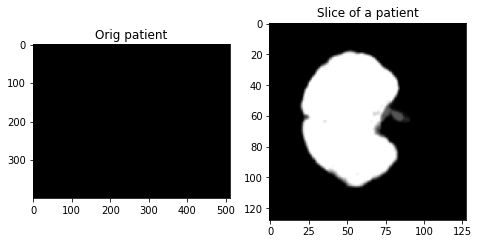

In [44]:
plt.figure('test', (12, 6))

plt.subplot(1, 3, 1)
plt.title('Orig patient')
plt.imshow(orig_patient['image'][0, 0, : ,: ,30], cmap= "gray")

plt.subplot(1, 3, 2)
plt.title('Slice of a patient')
plt.imshow(test_patient['image'][0, 0, : ,: ,30], cmap= "gray")

plt.show()